In [104]:
#necessary imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import string
import re


import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import concurrent.futures
import time
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import torch

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import seaborn as sns
!python -m spacy download en_core_web_lg


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [105]:
#loading the largest English model of spaCy
import en_core_web_lg

nlp = en_core_web_lg.load()

In [106]:
from google.colab import files
uploaded = files.upload()

Saving Case3_Dataset.csv to Case3_Dataset (2).csv


In [107]:
#Reading the data
data=pd.read_csv('Case3_Dataset.csv')

possible_labels = data.airline_sentiment.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

data['label'] = data.airline_sentiment.replace(label_dict)
data.head()

,airline_sentiment,airline,text,label
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,0
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,1
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,0
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,2
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,2


In [108]:
#splitting into train and test dataset
Y=data['label']
X=data

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1)

In [113]:
#dropping the columns that are not useful
X_test.drop(['airline_sentiment','label','airline'],axis='columns',inplace=True)
X_train.drop(['airline'],axis='columns',inplace=True)

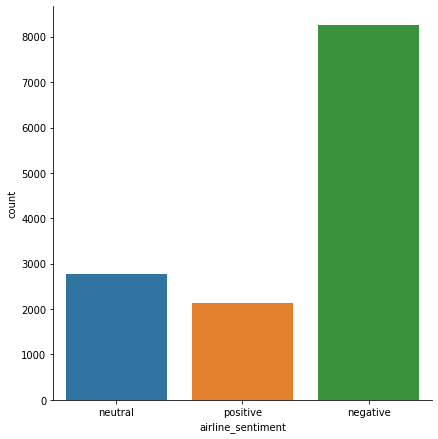

In [114]:
#plotting the number of different sentiments present in our dataset
sns.factorplot(x="airline_sentiment", data=X_train, kind="count", size=6)
plt.show();

##EDA

In [115]:
#storing the punctuations and list of stopwords available
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

In [116]:
#creating a parser for english language
parser = English()

#function for preprocessing the data
# Removing Stopwords and punctuations ; Converting the word to it's lemma ; Returning the preprocessed list
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = re.sub(r'@\w+', '', sentence)
    #mytokens = " ".join([i for i in mytokens])
    return mytokens

In [117]:
tqdm.pandas()
#creating another column in dataset for preprocessed text
X_train["processed_text"] = X_train["text"].progress_apply(spacy_tokenizer)
X_train.head()


100%|██████████| 13176/13176 [00:03<00:00, 3996.29it/s]


,airline_sentiment,text,label,processed_text
4620,neutral,@SouthwestAir are 5 people there?,0,are 5 people there?
360,neutral,@VirginAmerica i would like help with some fli...,0,i would like help with some flights please.
8880,neutral,@JetBlue do they have to depart from Washingto...,0,"do they have to depart from Washington, D.C.??"
12327,positive,@AmericanAir thanks for the recommendation. We...,1,thanks for the recommendation. We've been sit...
7274,positive,Kudos well deserved! Just wish the rest of my ...,1,Kudos well deserved! Just wish the rest of my ...


In [118]:
#converting the preprocessed text into vectors with minimum sentence length 3 and for alphabetical data 
vectorizer = CountVectorizer(min_df=3, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
#fit_transform the train_data
data_vectorized = vectorizer.fit_transform(X_train["processed_text"])

In [119]:
data_dense = data_vectorized.todense()

##LDA model

In [124]:
#applying LDA model on vectorized data and fit_transform the train data on it
lda = LatentDirichletAllocation(n_components=3, max_iter=10, learning_method='online',verbose=True,batch_size=64)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [125]:
#extracting the keywords that the model will use to identify 
def selected_topics(model, vectorizer, top_n=20):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 
        
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('flight', 993.3459635889899), ('time', 708.62998021564), ('just', 570.718085271489), ('gate', 463.85218865776415), ('plane', 444.11892502237737), ('bag', 440.1378277140892), ('don', 428.72477161660646), ('fly', 353.33495371171534), ('day', 303.43602104739716), ('amp', 288.20262459529806), ('change', 267.01863515166355), ('bags', 248.17652857505007), ('check', 242.43492547846856), ('luggage', 226.46531393162454), ('flying', 226.1403661698285), ('baggage', 222.57193470579844), ('lost', 219.05680041442162), ('work', 217.9663100334619), ('ticket', 201.6286756883267), ('didn', 191.61019841375298)]
Topic 1:
[('flight', 2522.3073498447297), ('thanks', 966.6547381205517), ('cancelled', 952.2017229300701), ('service', 859.0770858386195), ('customer', 682.4713108923231), ('hours', 604.8896980892098), ('hold', 596.5608381486942), ('thank', 565.4297260448798), ('help', 555.1055721753867), ('delayed', 500.67842982058477), ('need', 500.1546144728829), ('flightled', 460.37157745

As we can see here,                 
Topic 0 : Negative class                              
Topic 1 : Neutral class               
Topic 2 : Positive class